# Neural Network with PyTorch - Time Series Forecasting


In this Notebook:

- Preprocess CSV files and convert the data to Tensors
- Build your own Neural Network model with PyTorch
- Use a loss function and an optimizer to train your model
- Evaluate your model and learn about the perils of imbalanced classification

In [ ]:
# Heavily based on https://github.com/Prodicode/ann-visualizer

def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")
                c.node_attr.update(
                    width="0.65",
                    style="filled",
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],

                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data

Our dataset contains daily weather information from multiple Australian weather stations. We're about to answer a simple question. *Will it rain tomorrow?*

The data is hosted on [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) and created by [Joe Young](https://www.kaggle.com/jsphyg). I've uploaded the dataset to Google Drive. Let's get it:

In [1]:
import pandas as pd


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv('./data/weatherAUS.csv')
df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


In [2]:
df.tail(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No
145459,2017-06-25,Uluru,14.9,NaN,0.0,NaN,NaN,NaN,NaN,ESE,ESE,17.0,17.0,62.0,36.0,1020.2,1017.9,8.0,8.0,15.0,20.9,No,NaN


We have a large set of features/columns here. You might also notice some *NaN*s. Let's have a look at the overall dataset size:

In [3]:
df.shape

(145460, 23)

## Data Preprocessing

We'll simplify the problem by removing most of the data (mo money mo problems - Michael Scott). We'll use only 4 columns for predicting whether or not is going to rain tomorrow:

In [4]:
# convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# extract year, month, and day from datetime column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# drop the original Date column
df.drop('Date', axis=1, inplace=True)

In [5]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


In [6]:
from sklearn.impute import SimpleImputer
import numpy as np

imputers = {
    'mean': SimpleImputer(missing_values=np.nan, strategy='mean'),
    'median': SimpleImputer(missing_values=np.nan, strategy='median')
}

columns_to_impute = {
    'Evaporation': 'median',
    'Sunshine': 'mean',
    'Cloud3pm': 'median',
    'Cloud9am': 'mean',
    'Pressure9am': 'mean',
    'Pressure3pm': 'mean'
}

for column, strategy in columns_to_impute.items():
    df[[column]] = imputers[strategy].fit_transform(df[[column]])

In [7]:
df.isnull().sum()

Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation          0
Sunshine             0
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
Year                 0
Month                0
Day                  0
dtype: int64

In [8]:
# Drop missing values
df = df.dropna()

# Encode categorical variables to numeric ones
from sklearn.preprocessing import LabelEncoder

categorical_cols = [c for c in df.columns if df[c].dtype == 'object']
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [9]:
pd.concat([df.RainTomorrow.value_counts().to_frame("RainTomorrow"), 
           df.RainToday.value_counts().to_frame("RainToday")], axis=1)

,RainTomorrow,RainToday
0,94906,94537
1,26884,27253


In [10]:
def upsample_minority_class(df, column, target_size):
    zero_class = df[df[column] == 0]
    one_class = df[df[column] == 1]
    upsampled_one_class = resample(one_class, replace=True, n_samples=target_size)
    return pd.concat([zero_class, upsampled_one_class])

from sklearn.utils import resample, shuffle

df = upsample_minority_class(df, 'RainTomorrow', 80537)
df = shuffle(df)

df = upsample_minority_class(df, 'RainToday', 108000)
df = shuffle(df)

In [11]:
pd.concat([df.RainTomorrow.value_counts().to_frame("RainTomorrow"), 
           df.RainToday.value_counts().to_frame("RainToday")], axis=1)

,RainTomorrow,RainToday
1,120748,108000
0,110425,123173


In [12]:
X = df.drop(['RainTomorrow'], axis = 1)
y = df['RainTomorrow']

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs = SelectKBest(score_func=f_classif, k=15)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(231173, 15)


In [14]:
# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
X_new = X.iloc[:,cols]

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined

In [5]:
cols = ['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am', 'RainTomorrow'] 
df = df[cols]
df.head(2)

,MaxTemp,Rainfall,Evaporation,Sunshine,Pressure9am,RainTomorrow
Date,,,,,,
2008-12-01,22.9,0.6,NaN,NaN,1007.7,No
2008-12-02,25.1,0.0,NaN,NaN,1010.6,No


In [6]:
df.shape

(145460, 6)

In [8]:
print(df.nunique())

MaxTemp         505
Rainfall        681
Evaporation     358
Sunshine        145
Pressure9am     546
RainTomorrow      2
dtype: int64


In [7]:
from sklearn.impute import SimpleImputer

# Handle missing value (Impute the missing values)
imputer = SimpleImputer(strategy='mean')
df[['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']] = imputer.fit_transform(df[['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']])

In [8]:
from sklearn.preprocessing import LabelEncoder

#Encode categorical target variable
le = LabelEncoder()
df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

In [10]:
from sklearn.preprocessing import StandardScaler

# Normalize/scale the data
scaler = StandardScaler()
df[['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']] = scaler.fit_transform(df[['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']])

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
target = torch.nn.functional.one_hot(labels, num_classes=2)

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # input layer (6) -> hidden layer (64)
        self.fc2 = nn.Linear(64, 2)  # hidden layer (64) -> output layer (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        x = self.fc2(x)
        return x

model = Net()

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [38]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

RuntimeError: Expected target size [32, 2], got [32]

In [12]:
from torch.utils.data import Dataset, DataLoader

# Create sequences for time series forecasting (for next 30 days)
class RainDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x = self.X.iloc[idx:idx + self.seq_len].values
        y = self.y.iloc[idx + self.seq_len - 1]
        return x, y

seq_len = 30
batch_size = 32

train_dataset = RainDataset(X_train, y_train, seq_len)
test_dataset = RainDataset(X_test, y_test, seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RainModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = F.softmax(out, dim=1)
        return out

# Initialize the model, criterion, and optimizer
model = RainModel(input_dim=1, hidden_dim=10, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    for x, y in train_loader:
        x, y_binary = x.to(device), (y > 0).long().to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y_binary)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 5

In [25]:
# Create a PyTorch model - Define a simple recurrent neural network (RNN) model using PyTorch:
import torch
import torch.nn as nn
import torch.nn.functional as F  # <--- Add this line

class RainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RainModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = F.softmax(out, dim=1)  # Now F is defined
        return out

input_dim = 5  # number of features
hidden_dim = 128
output_dim = 2  # binary classification (Yes/No)

model = RainModel(input_dim, hidden_dim, output_dim)

In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
import torch.nn.functional as F

# Train the model using the training data loader:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(10):  # train for 10 epochs
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

IndexError: Target 2 is out of bounds.

In [ ]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()

accuracy = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss / len(test_loader)}')
print(f'Test Accuracy: {accuracy:.2f}%')

## Handle Missing Values

I use linear interpolation to fill in the missing values. This method uses the average of the previous and next values to fill in the missing value.


In [9]:
# Define a function to perform linear interpolation
def linear_interpolate(df, col):
    df[col] = df[col].interpolate(method='linear', limit_direction='both')
    return df

# Apply the function to each column
columns_to_interpolate = ['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']
for col in columns_to_interpolate:
    df = linear_interpolate(df, col)

## Encode Categorical Variables

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

## Normalize/Scale Features

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']] = scaler.fit_transform(df[['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']])

## Split Data into Training and Testing Sets

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(['RainTomorrow'], axis=1)
y_tomorrow = df['RainTomorrow']

X_train, X_test, y_train_tomorrow, y_test_tomorrow = train_test_split(X, y_tomorrow, test_size=0.2, random_state=42)

## Convert Data to Tensors

In [15]:
import torch

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tomorrow_tensor = torch.tensor(y_train_tomorrow.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tomorrow_tensor = torch.tensor(y_test_tomorrow.values, dtype=torch.long)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class RainPredictor(nn.Module):
    def __init__(self):
        super(RainPredictor, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # input layer (5) -> hidden layer (128)
        self.fc2 = nn.Linear(128, 64)  # hidden layer (128) -> hidden layer (64)
        self.fc3 = nn.Linear(64, 2)  # hidden layer (64) -> output layer (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = RainPredictor()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(100):  # loop over the dataset multiple times
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tomorrow_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model on the test set
model.eval()
test_outputs = model(X_test_tensor)
_, predicted = torch.max(test_outputs, 1)
accuracy = (predicted == y_test_tomorrow_tensor).sum().item() / len(y_test_tomorrow_tensor)
print(f'Test Accuracy: {accuracy:.2f}%')

IndexError: Target 2 is out of bounds.

In [29]:
pd.set_option('future.no_silent_downcasting', True)
df['RainToday'] = df['RainToday'].replace({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].replace({'No': 0, 'Yes': 1})

Let's drop the rows with missing values. There are better ways to do this, but we'll keep it simple:

In [30]:
df = df.dropna(how='any')
df.head()

,MaxTemp,Rainfall,Evaporation,Sunshine,Pressure9am,RainToday,RainTomorrow
Date,,,,,,,
2009-01-01,35.2,0.0,12.0,12.3,1006.3,0,0
2009-01-02,28.9,0.0,14.8,13.0,1012.9,0,0
2009-01-04,37.6,0.0,10.8,10.6,1012.3,0,0
2009-01-05,38.4,0.0,11.4,12.2,1012.7,0,0
2009-01-06,41.0,0.0,11.2,8.4,1010.7,0,0


In [31]:
df.describe()

,MaxTemp,Rainfall,Evaporation,Sunshine,Pressure9am
count,70066.000000,70066.000000,70066.000000,70066.000000,70066.000000
mean,23.635509,2.084515,5.285465,7.598499,1017.437366
std,6.930482,6.727859,3.668944,3.774685,7.071299
min,4.100000,0.000000,0.000000,0.000000,980.500000
25%,18.200000,0.000000,2.600000,4.800000,1012.800000
50%,23.000000,0.000000,4.600000,8.400000,1017.400000
75%,28.900000,0.800000,7.200000,10.600000,1022.200000
max,48.100000,206.200000,81.200000,14.500000,1040.900000


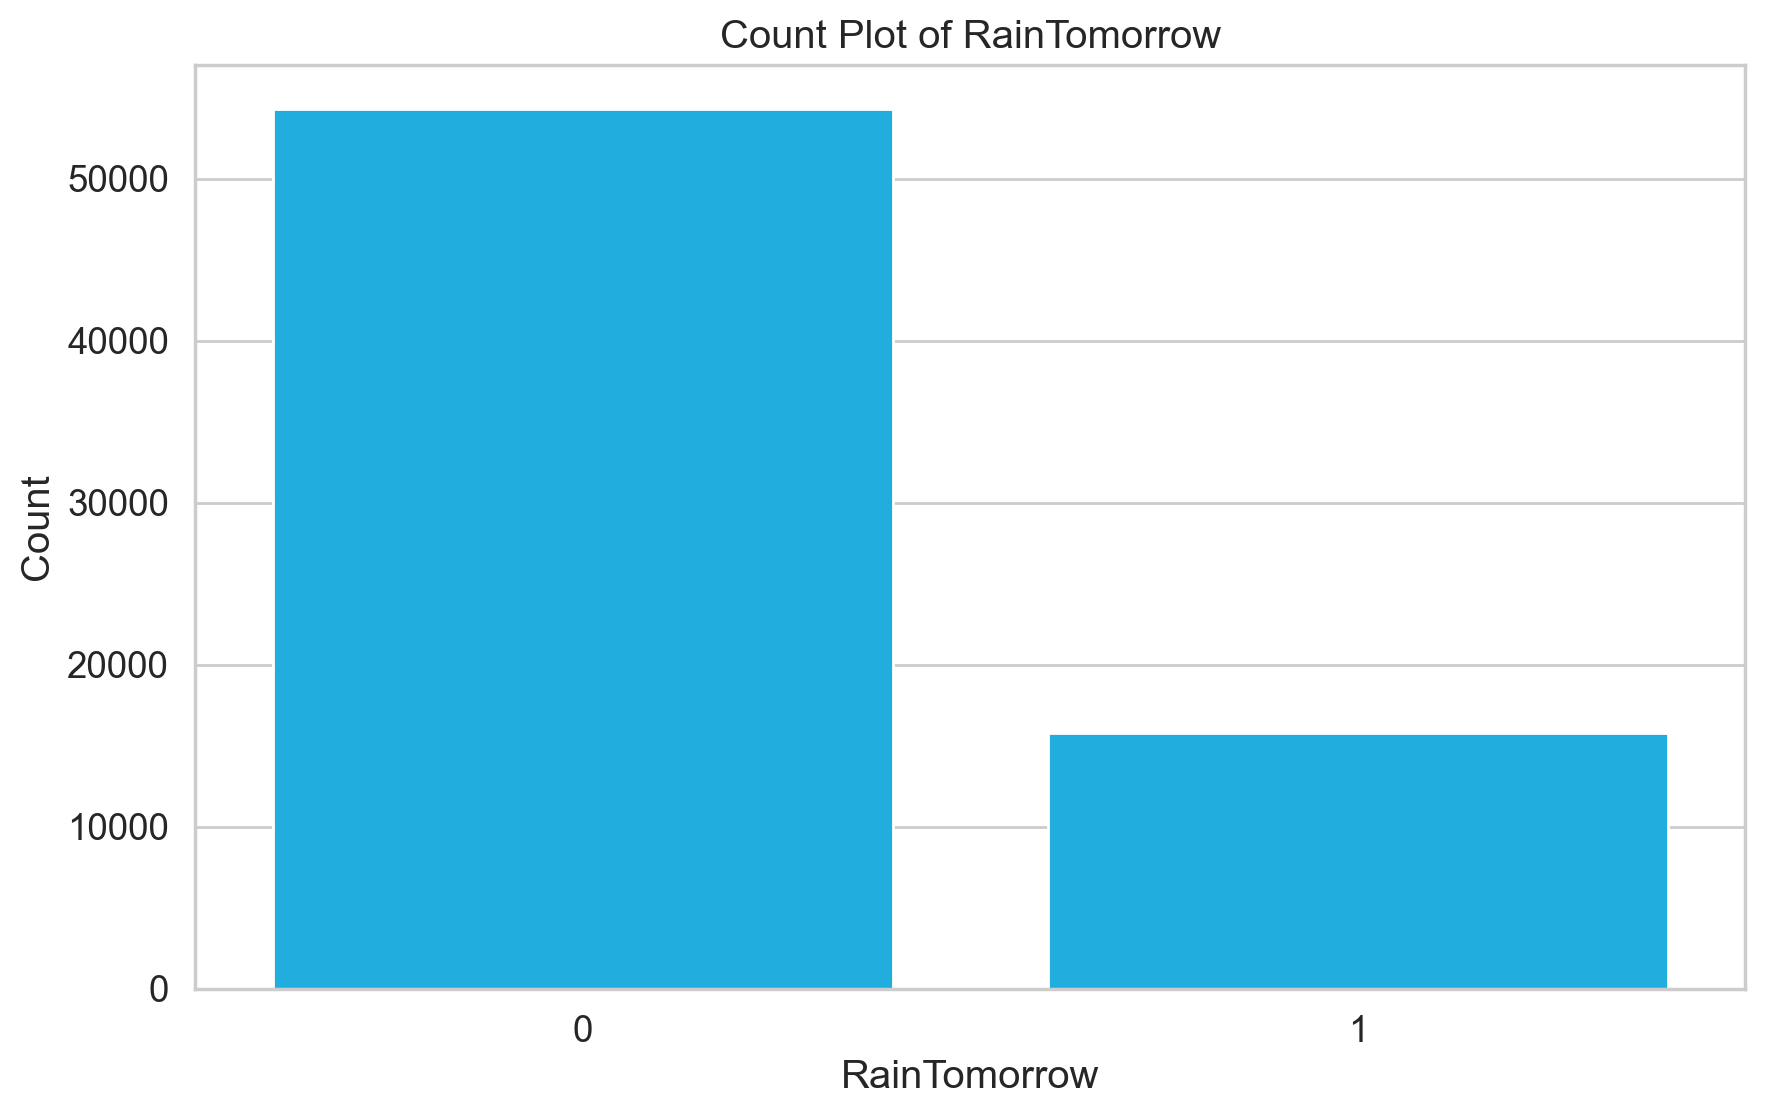

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(x='RainTomorrow', data=df)
plt.title('Count Plot of RainTomorrow')
plt.xlabel('RainTomorrow')
plt.ylabel('Number of days')
plt.show()

In [37]:
df.RainTomorrow.value_counts() / df.shape[0]

RainTomorrow
0    0.775312
1    0.224688
Name: count, dtype: float64

In [19]:
from sklearn.preprocessing import StandardScaler

df_scaled = ['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'Pressure9am']

Finally, we have a dataset we can work with.

One important question we should answer is - *How balanced is our dataset?* Or *How many times did it rain or not rain tomorrow?*:

Things are not looking good. About 78% of the data points have a non-rainy day for tomorrow. This means that a model that predicts there will be no rain tomorrow will be correct about 78% of the time.

You can read and apply the [Practical Guide to Handling Imbalanced Datasets](https://www.curiousily.com/posts/practical-guide-to-handling-imbalanced-datasets/) if you want to mitigate this issue. Here, we'll just hope for the best.

The final step is to split the data into train and test sets:

In [8]:
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0,0
1,0.0,25.0,1010.6,0,0
2,0.0,30.0,1007.6,0,0
3,0.0,16.0,1017.6,0,0
4,1.0,33.0,1010.8,0,0


In [13]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Create a copy of the original DataFrame
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']].copy()

# One-hot encode the categorical column 'RainToday'
X = pd.get_dummies(X, columns=['RainToday'])

# Check the data types of the columns in X
print(X.dtypes)

# Convert any remaining non-numeric columns to float
for col in X.columns:
    if X[col].dtype == object:
        X[col] = X[col].astype(float)

y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Convert the pandas DataFrames to NumPy arrays first
X_train = torch.from_numpy(X_train.values).float()
y_train = torch.squeeze(torch.from_numpy(y_train.values).float())

X_test = torch.from_numpy(X_test.values).float()
y_test = torch.squeeze(torch.from_numpy(y_test.values).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Rainfall       float64
Humidity3pm    float64
Pressure9am    float64
RainToday_0       bool
RainToday_1       bool
dtype: object


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [9]:
import pandas as pd

# Assuming 'RainToday' is a categorical column
X = pd.get_dummies(X, columns=['RainToday'])

In [10]:
import torch
from sklearn.model_selection import train_test_split

# Convert non-numeric columns to numeric types
X = pd.get_dummies(X, columns=['RainToday'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Convert the pandas DataFrames to NumPy arrays first
X_train = torch.from_numpy(X_train.values).float()
y_train = torch.squeeze(torch.from_numpy(y_train.values).float())

X_test = torch.from_numpy(X_test.values).float()
y_test = torch.squeeze(torch.from_numpy(y_test.values).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

KeyError: "None of [Index(['RainToday'], dtype='object')] are in the [columns]"

In [19]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

And convert all of it to Tensors (so we can use it with PyTorch):

In [24]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

AttributeError: 'Tensor' object has no attribute 'to_numpy'

## Building a Neural Network

We'll build a simple Neural Network (NN) that tries to predicts will it rain tomorrow.

Our input contains data from the four columns: `Rainfall, Humidity3pm, RainToday, Pressure9am`. We'll create an appropriate input layer for that.

The output will be a number between 0 and 1, representing how likely (our model thinks) it is going to rain tomorrow. The prediction will be given to us by the final (output) layer of the network.

We'll add two (hidden) layers between the input and output layers. The parameters (neurons) of those layer will decide the final output. All layers will be fully-connected.

One easy way to build the NN with PyTorch is to create a class that inherits from `torch.nn.Module`:


In [ ]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

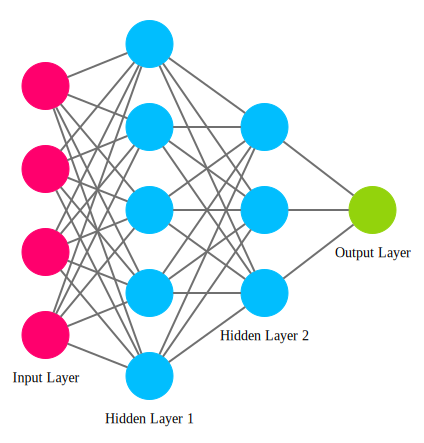

In [ ]:
net = Net(X_train.shape[1])

ann_viz(net, view=False)

We start by creating the layers of our model in the constructor. The `forward()` method is where the magic happens. It accepts the input `x` and allows it to flow through each layer.

There is a corresponding backward pass (defined for you by PyTorch) that allows the model to learn from the errors that is currently making.

### Activation Functions

You might notice the calls to `F.relu` and `torch.sigmoid`. Why do we need those?

One of the cool *features* of Neural Networks is that they can approximate non-linear functions. In fact, [it is proven that they can approximate any function](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

Good luck approximating non-linear functions by stacking linear layers, though.  Activation functions allow you to break from the linear world and learn (hopefully) more. You'll usually find them applied to an output of some layer.

Those functions must be hard to define, right?

#### ReLU

Not at all, let start with the ReLU definition (one of the most widely used activation function):

$$
\text{ReLU}(x) = \max({0, x})
$$

Easy peasy, the result is the maximum value of zero and the input.

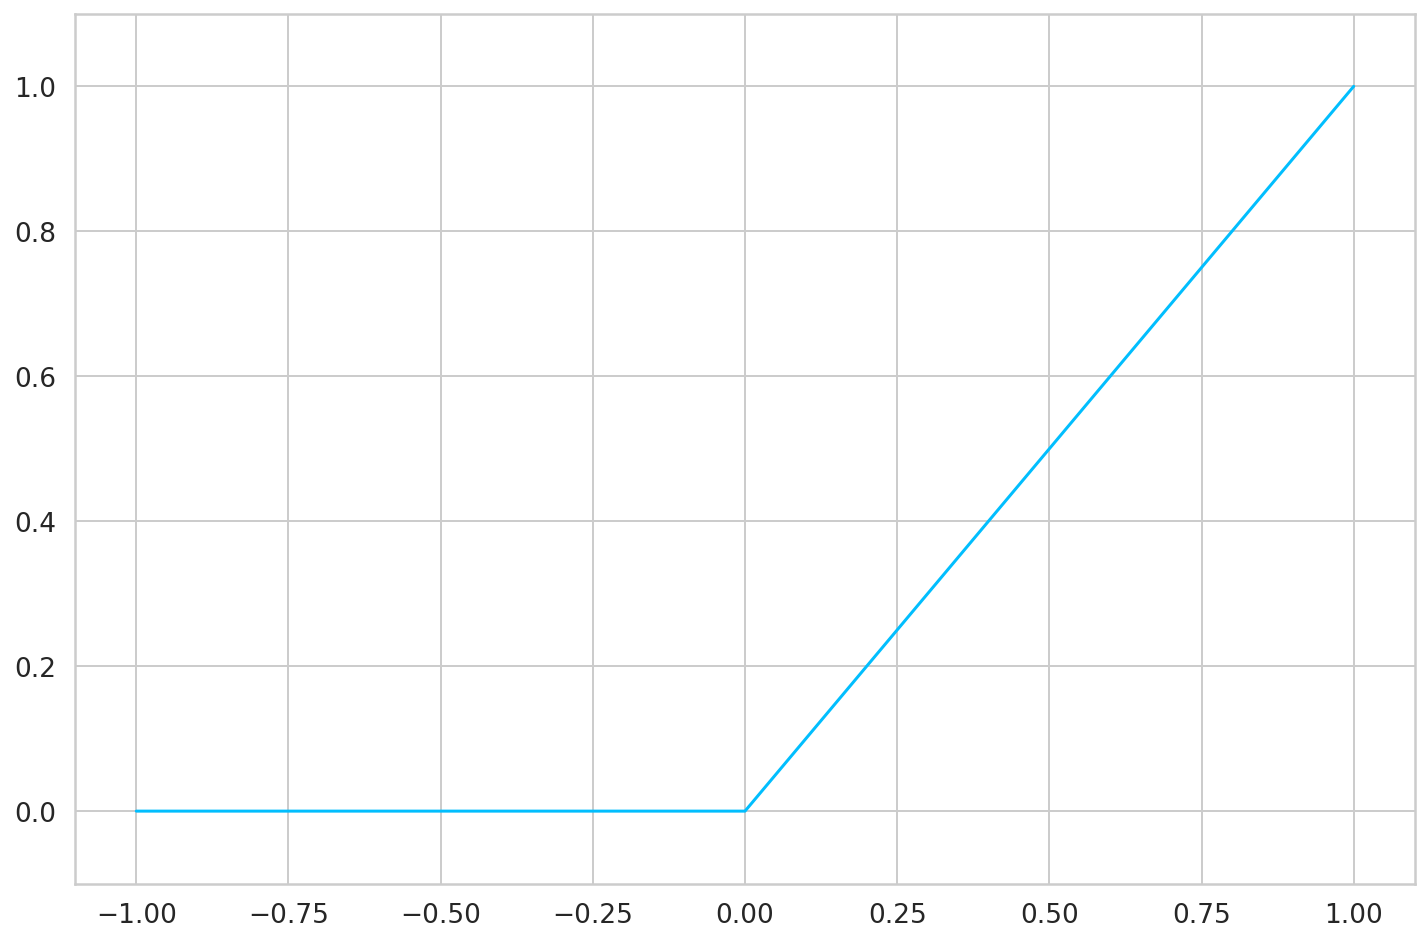

In [ ]:
ax = plt.gca()

plt.plot(
  np.linspace(-1, 1, 5),
  F.relu(torch.linspace(-1, 1, steps=5)).numpy()
)
ax.set_ylim([-0.1, 1.1]);

#### Sigmoid

The sigmoid is useful when you need to make a binary decision/classification (answering with a *yes* or a *no*).

It is defined as:

$$\text{Sigmoid}(x) = \frac{1}{1+e^{-x}}$$

The sigmoid squishes the input values between 0 and 1. But in a super kind of way:

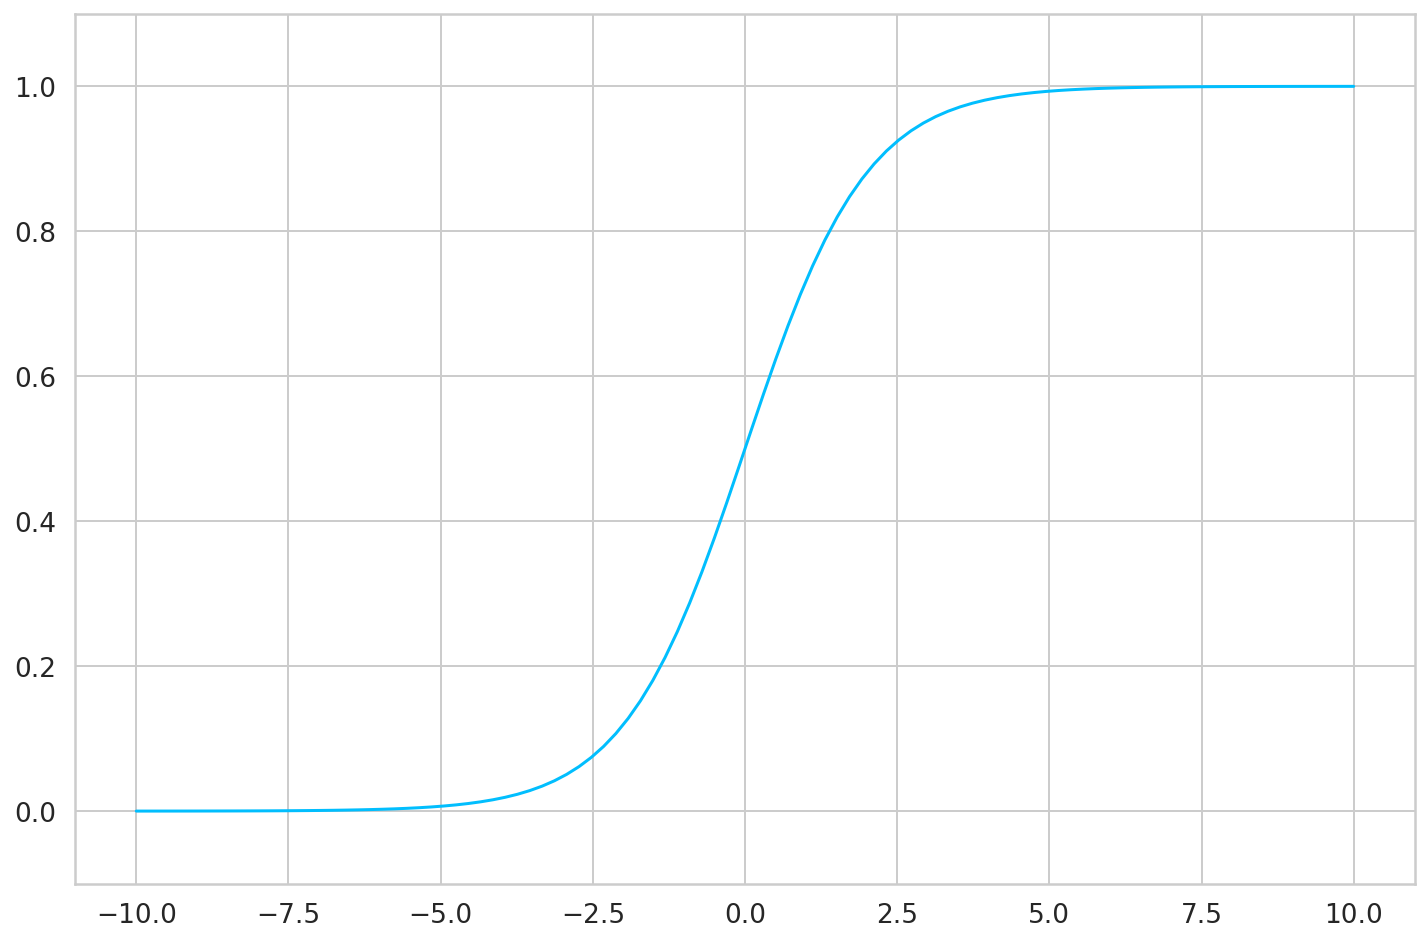

In [ ]:
ax = plt.gca()

plt.plot(
  np.linspace(-10, 10, 100),
  torch.sigmoid(torch.linspace(-10, 10, steps=100)).numpy()
)
ax.set_ylim([-0.1, 1.1]);

## Training

With the model in place, we need to find parameters that predict will it rain tomorrow. First, we need something to tell us how good we're currently doing:

In [ ]:
criterion = nn.BCELoss()

The [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss) is a loss function that measures the difference between two binary vectors. In our case, the predictions of our model and the real values. It expects the values to be outputed by the sigmoid function. The closer this value gets to 0, the better your model should be.

But how do we find parameters that minimize the loss function?

### Optimization

Imagine that each parameter of our NN is a knob. The optimizer's job is to find the perfect positions for each knob so that the loss gets close to 0.

Real-world models can contain millions or even billions of parameters. With so many knobs to turn, it would be nice to have an efficient optimizer that quickly finds solutions.

Contrary to what you might believe, optimization in Deep Learning is just satisfying. In practice, you're content with good enough parameter values that give you an acceptable accuracy.

While there are tons of optimizers you can choose from, [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) is a safe first choice. PyTorch has a well-debugged implementation you can use:

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

Naturally, the optimizer requires the parameters. The second argument `lr` is *learning rate*. It is a tradeoff between how good parameters you're going to find and how fast you'll get there. Finding good values for this can be black magic and a lot of brute-force "experimentation".

### Doing it on the GPU

Doing massively parallel computations on GPUs is one of the enablers for modern Deep Learning. You'll need nVIDIA GPU for that.

PyTorch makes it really easy to transfer all the computation to your GPU:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
net = net.to(device)

criterion = criterion.to(device)

We start by checking whether or not a CUDA device is available. Then, we transfer all training and test data to that device. Finally, we move our model and loss function.

### Weather Forecasting

Having a loss function is great, but tracking the accuracy of our model is something easier to understand, for us mere mortals. Here's the definition for our accuracy:

In [ ]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

We convert every value below 0.5 to 0. Otherwise, we set it to 1. Finally, we calculate the percentage of correct values.

With all the pieces of the puzzle in place, we can start training our model:

In [ ]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):

    y_pred = net(X_train)

    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

epoch 0
Train set - loss: 2.513, accuracy: 0.779
Test  set - loss: 2.517, accuracy: 0.778

epoch 100
Train set - loss: 0.457, accuracy: 0.792
Test  set - loss: 0.458, accuracy: 0.793

epoch 200
Train set - loss: 0.435, accuracy: 0.801
Test  set - loss: 0.436, accuracy: 0.8

epoch 300
Train set - loss: 0.421, accuracy: 0.814
Test  set - loss: 0.421, accuracy: 0.815

epoch 400
Train set - loss: 0.412, accuracy: 0.826
Test  set - loss: 0.413, accuracy: 0.827

epoch 500
Train set - loss: 0.408, accuracy: 0.831
Test  set - loss: 0.408, accuracy: 0.832

epoch 600
Train set - loss: 0.406, accuracy: 0.833
Test  set - loss: 0.406, accuracy: 0.835

epoch 700
Train set - loss: 0.405, accuracy: 0.834
Test  set - loss: 0.405, accuracy: 0.835

epoch 800
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.835

epoch 900
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.836



During the training, we show our model the data for `10,000` times. Each time we measure the loss, propagate the errors trough our model and asking the optimizer to find better parameters.

The `zero_grad()` method clears up the accumulated gradients, which the optimizer uses to find better parameters.

What about that accuracy? 83.6% accuracy on the test set sounds reasonable, right? Well, I am about to disappoint you. But first, let's learn how to save and load our trained models.

## Saving the model

Training a good model can take a lot of time. And I mean weeks, months or even years. So, let's make sure that you know how you can save your precious work. Saving is easy:

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Restoring your model is easy too:

In [ ]:
net = torch.load(MODEL_PATH)

## Evaluation

Wouldn't it be perfect to know about all the errors your model can make? Of course, that's impossible. But you can get an estimate.

Using just accuracy wouldn't be a good way to do it. Recall that our data contains mostly no rain examples.

One way to delve a bit deeper into your model performance is to assess the precision and recall for each class. In our case, that will be *no rain* and *rain*:

In [ ]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.80      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



 A maximum precision of 1 indicates that the model is perfect at identifying only relevant examples. A maximum recall of 1 indicates that our model can find all relevant examples in the dataset for this class.

 You can see that our model is doing good when it comes to the *No rain* class. We have so many examples. Unfortunately, we can't really trust predictions of the *Raining* class.

 One of the best things about binary classification is that you can have a good look at a simple confusion matrix:

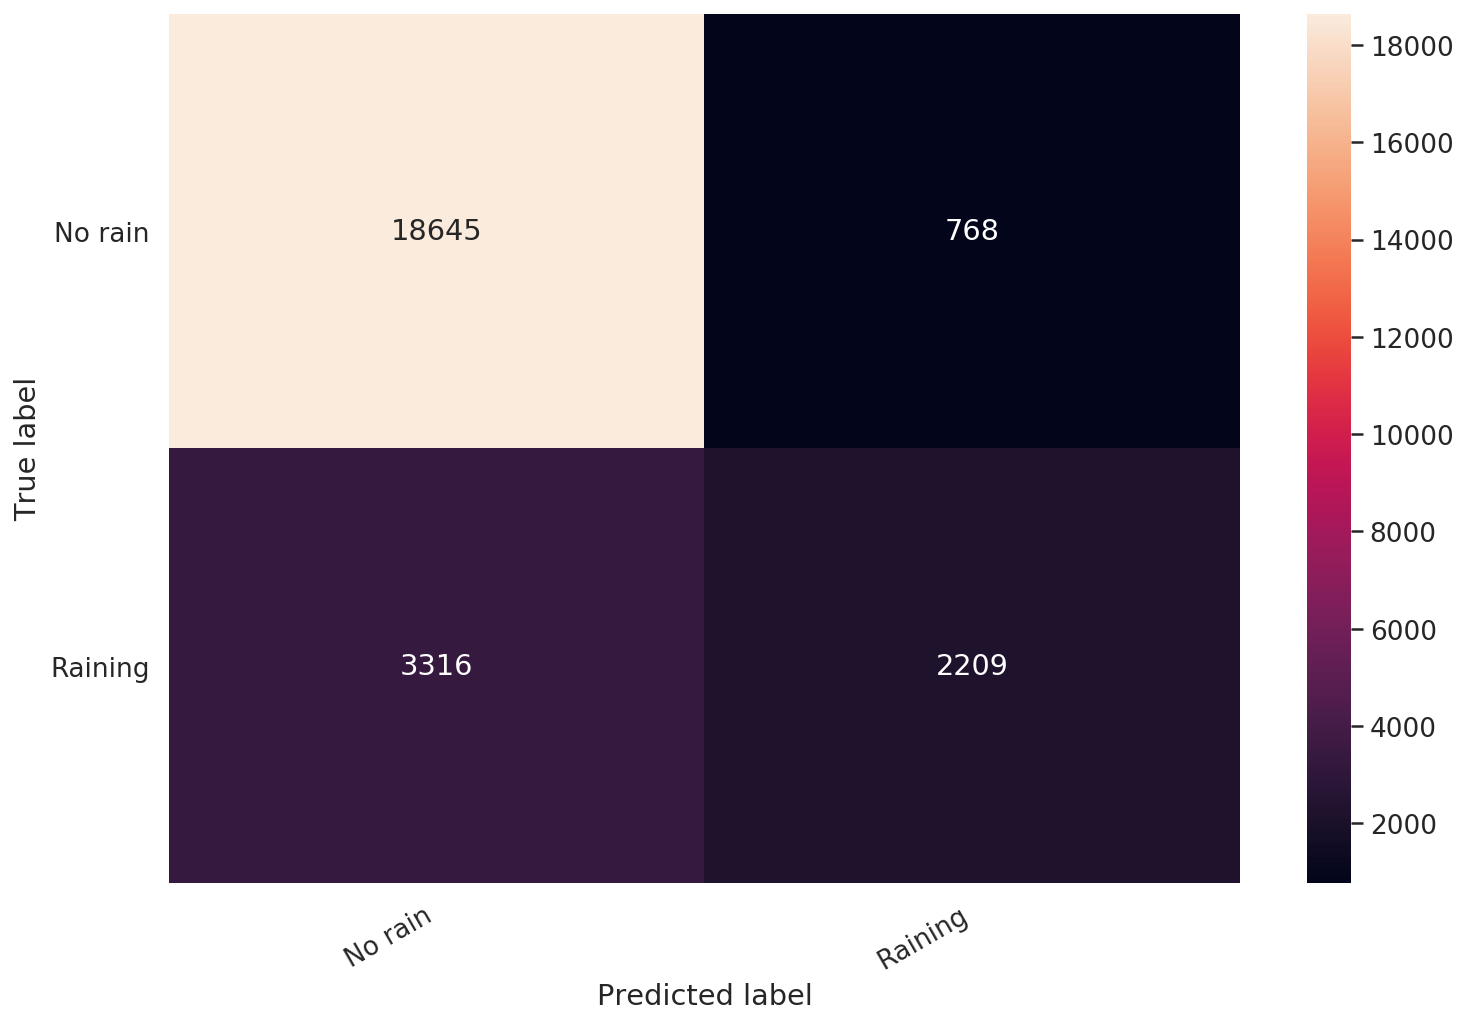

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

You can clearly see that our model shouldn't be trusted when it says it's going to rain.

## Making Predictions

Let's pick our model's brain and try it out on some hypothetical examples:

In [ ]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

This little helper will return a binary response based on your model predictions. Let's try it out:

In [ ]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

True

In [ ]:
will_it_rain(rainfall=0, humidity=1, rain_today=False, pressure=100)

False

Okay, we got two different responses based on some parameters (yep, the power of the brute force). Your model is ready for deployment (but please don't)!

## Conclusion

Well done! You now have a Neural Network that can predict the weather. Well, sort of. Building well-performing models is hard, really hard. But there are tricks you'll pick up along the way and (hopefully) get better at your craft!

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1lDXVkdt7GC8jK_nGmOMKeDywXse-DY-u)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Preprocess CSV files and convert the data to Tensors
- Build your own Neural Network model with PyTorch
- Use a loss function and an optimizer to train your model
- Evaluate your model and learn about the perils of imbalanced classification

## References

- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)
- [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)